In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# data augmentation
import albumentations as A

from albumentations.pytorch import ToTensorV2

# pretrained models
import torchvision
from torchvision import models, transforms

In [16]:
!pwd

/Users/okeefe/Box/USF Data Science Practicum/2020-21/Okeefe/Project_2_Resilience_Building_Classifier


In [4]:
data_path = '/Users/okeefe/Box/USF Data Science Practicum/2020-21/Resilience_Project/2000_per_label_images/'

rows = []

for label in os.listdir(data_path):
    for image in os.listdir(data_path + f'/{label}'):
        row = dict()
        row['image_file'] = image
        row['label'] = label

        # a bit redudant, could build from other data in __getitem__ if wanted
        row['image_path'] = data_path + f'/{label}'
        rows.append(row)
        
df = pd.DataFrame(rows[1:])
print(len(df))
df.head()

3300


,image_file,label,image_path
0,4001p15.jpg,commercial,/Users/okeefe/Box/USF Data Science Practicum/2...
1,4002p15.jpg,commercial,/Users/okeefe/Box/USF Data Science Practicum/2...
2,4006p0.jpg,commercial,/Users/okeefe/Box/USF Data Science Practicum/2...
3,4007p30.jpg,commercial,/Users/okeefe/Box/USF Data Science Practicum/2...
4,4008p0.jpg,commercial,/Users/okeefe/Box/USF Data Science Practicum/2...


In [65]:
from albumentations.pytorch import ToTensorV2

class BuildingImagesDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        self.label_dict = {label:idx for idx, label in enumerate(df.label.unique())}
        
        # Randomly augment images for variety
        self.transforms = A.Compose([
            # spatial transforms
            A.RandomCrop(width=500, height=500),
            A.HorizontalFlip(p=.5),
            A.VerticalFlip(p=.5),
            A.Rotate(limit = 10, 
                     border_mode = cv2.BORDER_CONSTANT, 
                     value = 0.0, p = .75),

            # pixel-level transformation
            A.RandomBrightnessContrast(p=0.1),

            # we will normalize according to ImageNet since we will be using a pre-trained ResNet
            # this adjusts from [0,255] to [0,1]
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

            # convert to a tensor and move color channels
            ToTensorV2()
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        path = row['image_path'] + f"/{row['image_file']}"
        
        img = cv2.imread(path)
        
        img = cv2.cvtColor(img, cv2. COLOR_BGR2RGB)
        
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        #Scale to v
        img = ((img - img.min()) / (img.max()-img.min()))
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

In [66]:
ds = BuildingImagesDataset(df)

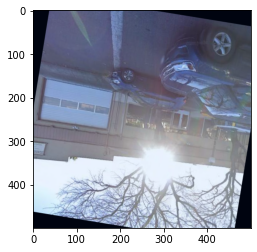

In [71]:
img = np.transpose(ds[1994][0], (1, 2, 0))
plt.imshow(img)

In [82]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)
df_train, df_valid = train_test_split(df_train)

ds_train = BuildingImagesDataset(df_train)
ds_valid = BuildingImagesDataset(df_valid)

dl_train = DataLoader(ds_train, batch_size = 16, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size = 16, shuffle=False)

# Create CNN Model:

In [85]:
resnet = models.resnet18(pretrained=True)

In [86]:
from torchsummary import summary
summary(resnet, input_size = (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [93]:
for param in resnet.parameters():
            param.requires_grad = False
        
resnet.fc = nn.Linear(512, 4, bias = True)

for name, param in resnet.named_parameters():
    print(f"{name} gradient is set to", param.requires_grad)

conv1.weight gradient is set to False
bn1.weight gradient is set to False
bn1.bias gradient is set to False
layer1.0.conv1.weight gradient is set to False
layer1.0.bn1.weight gradient is set to False
layer1.0.bn1.bias gradient is set to False
layer1.0.conv2.weight gradient is set to False
layer1.0.bn2.weight gradient is set to False
layer1.0.bn2.bias gradient is set to False
layer1.1.conv1.weight gradient is set to False
layer1.1.bn1.weight gradient is set to False
layer1.1.bn1.bias gradient is set to False
layer1.1.conv2.weight gradient is set to False
layer1.1.bn2.weight gradient is set to False
layer1.1.bn2.bias gradient is set to False
layer2.0.conv1.weight gradient is set to False
layer2.0.bn1.weight gradient is set to False
layer2.0.bn1.bias gradient is set to False
layer2.0.conv2.weight gradient is set to False
layer2.0.bn2.weight gradient is set to False
layer2.0.bn2.bias gradient is set to False
layer2.0.downsample.0.weight gradient is set to False
layer2.0.downsample.1.weight

In [111]:
def optimizer_params(model, max_lr=0.01):
    """
    Scales the optimizer parameters:
    learning rate
    """

    # The deeper into the model, the smaller the learning rate
    params = []
    
    for i, layer in enumerate(model.children()):
        if i < 6:
            params.append({'params': layer.parameters(), 'lr': max_lr / 100})
        elif 5 < i < 9:
            params.append({'params': layer.parameters(), 'lr': max_lr / 10})
        else:
            params.append({'params': layer.parameters()})

    return params

params = optimizer_params(resnet)

# Creating Training Loop

In [94]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

# Fine Tuning the Model

In [167]:
for name, param in resnet.named_parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [173]:
all_params = []

for name, param in resnet.named_parameters():
    param.requires_grad = False
    all_params.append(param)
    
for param in all_params[-2:]:
    param.requires_grad = True

step = 62 // num_epochs

for i in range(1, num_epochs + 1):
    print("Epoch: ", i)
    for param in all_params[-i*step:]:
        param.requires_grad = True

    for name, param in resnet.named_parameters():
            print(param.requires_grad)

Epoch:  1
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
Epoch:  2
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Epoch:  3
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
T

In [175]:
def update_optimizer(model, i, num_epochs):
    step = 62 // num_epochs
    
    all_params = []
    
    for name, param in resnet.named_parameters():
        all_params.append(param)
        
    for param in all_params[-i*step:]:
        param.requires_grad = True

    params = optimizer_params(model)
        
    optimizer = optim.AdamW(params, lr=0.01)

    return optimizer

In [177]:
from tqdm.notebook import tqdm

lossFun = nn.CrossEntropyLoss()

params_to_update = []

for param in resnet.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = optim.AdamW(params_to_update, lr=0.01)

num_epochs = 10
train_losses = []
valid_losses = []

for i, epoch in tqdm(enumerate(range(num_epochs))):
    print('Epoch: ', epoch)
    
    optimizer = update_optimizer(resnet, i, num_epochs)
    
    train_loss = one_pass(resnet, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(resnet, dl_valid, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(resnet, dl_train, len(ds_train))
    valid_acc = one_pass_acc(resnet, dl_valid, len(ds_valid))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

0it [00:00, ?it/s]

Epoch:  0


  0%|          | 0/116 [00:00<?, ?it/s]

error: OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-gt63l4kp/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
